# Demo RNA Multi-Perceptrón Backpropagation usando Keras para procesar las imágenes de personajes de los simpsons e identificar a cual corresponse

1) Cargar librerías:

In [24]:
import random
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Librerías cargadas")

Librerías cargadas


2) Definir los parámetros:

In [41]:
# tamaño de las imágenes
IMAGE_SHAPE = (60, 60, 3)

# indica si se usan las imágenes generadas por data augmentation
usarDA = False

# define tamaño de datos de entrada 
num_inputs = IMAGE_SHAPE[0] * IMAGE_SHAPE[1] * IMAGE_SHAPE[2]

# define tamaño de datos de salida (las clases están codificadas en un único número)
num_outputs = 1 

# cantidad de neuronas ocultas 
##hidden_layers = [ 896, 84, 8 ] 
hidden_layers = [ num_inputs//5, num_inputs//20, num_inputs//100 ]

# cantidad de épocas del entrenamiento
cantEpocas = 300

map_characters = {
    0: 'abraham_grampa_simpson',
    1: 'homer_simpson',
    2: 'otto_mann',
    3: 'agnes_skinner',
    4: 'kent_brockman',
    5: 'patty_bouvier',
    6: 'apu_nahasapeemapetilon',
    7: 'krusty_the_clown',
    8: 'principal_skinner',
    9: 'barney_gumble',
    10: 'lenny_leonard',
    11: 'professor_john_frink',
    12: 'bart_simpson',
    13: 'lionel_hutz',
    14: 'rainier_wolfcastle',
    15: 'carl_carlson',
    16: 'lisa_simpson',	       
    17: 'ralph_wiggum',
    18: 'charles_montgomery_burns',
    19: 'maggie_simpson', 
    20: 'selma_bouvier',
    21: 'chief_wiggum',
    22: 'marge_simpson',
    23: 'sideshow_bob',
    24: 'cletus_spuckler',
    25: 'martin_prince',
    26: 'sideshow_mel',
    27: 'comic_book_guy',
    28: 'mayor_quimby',
    29:	'simpsons_dataset',
    30: 'disco_stu',
    31: 'milhouse_van_houten',
    32: 'snake_jailbird',
    33: 'edna_krabappel',
    34: 'miss_hoover',
    35: 'troy_mcclure',
    36: 'fat_tony',
    37: 'moe_szyslak',
    38: 'waylon_smithers',
    39: 'gil',
    40: 'ned_flanders',
    41: 'groundskeeper_willie',
    42:	'nelson_muntz'

}
print("Configuración de RNA MLP Backpropagation definida: [", num_inputs, hidden_layers, num_outputs," ] ")

Configuración de RNA MLP Backpropagation definida: [ 10800 [2160, 540, 108] 1  ] 


3) Montar el Drive:

In [39]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#!unzip "/content/drive/My Drive/I.A. GRUPO/T2 - TheSimpsons/dataset.zip"

image_pathes = 'simpsons_dataset'
!rm -rf simpsons_dataset/simpsons_dataset
 

Mounted at /content/drive


4) Cargar imágenes para entrenar el modelo:

['cletus_spuckler', 'agnes_skinner', 'patty_bouvier', 'waylon_smithers', 'mayor_quimby', 'gil', 'troy_mcclure', 'selma_bouvier', 'snake_jailbird', 'lionel_hutz', 'ralph_wiggum', 'milhouse_van_houten', 'miss_hoover', 'carl_carlson', 'martin_prince', 'apu_nahasapeemapetilon', 'marge_simpson', 'ned_flanders', 'chief_wiggum', 'kent_brockman', 'lenny_leonard', 'otto_mann', 'fat_tony', 'nelson_muntz', 'lisa_simpson', 'groundskeeper_willie', 'homer_simpson', 'moe_szyslak', 'krusty_the_clown', 'maggie_simpson', 'charles_montgomery_burns', 'rainier_wolfcastle', 'bart_simpson', 'disco_stu', 'sideshow_mel', 'professor_john_frink', 'comic_book_guy', 'principal_skinner', 'barney_gumble', 'edna_krabappel', 'abraham_grampa_simpson', 'sideshow_bob']
#####
simpsons_dataset/cletus_spuckler
['pic_0019.jpg', 'pic_0034.jpg', 'pic_0030.jpg', 'pic_0039.jpg', 'pic_0025.jpg', 'pic_0024.jpg', 'pic_0031.jpg', 'pic_0011.jpg', 'pic_0016.jpg', 'pic_0021.jpg', 'pic_0035.jpg', 'pic_0042.jpg', 'pic_0027.jpg', 'pic_002

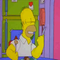



> Para Prueba: 
- Imágenes cargadas:  4189
- Ejemplo  bart_simpson   (60, 60, 3) : 


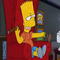

In [43]:
# define función para cargar las imágenes
def cargarImagenes(imagPath):
  classes_ori = [] 
  images_ori = []

  all_dirs = os.listdir( imagPath )
  print(all_dirs)
  for each_dir in all_dirs:
      auxiPath = imagPath + '/' + each_dir 
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:
        # abre la imagen
        imag = Image.open(auxiPath + "/" + each_imagFN)
        
        # ajusta el tamaño
        imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.ANTIALIAS)          
        
        # transforma a un vector de nros
        arImag = np.array(imag)
        
        # agrega a los vectores
        classes_ori.append( each_dir )
        images_ori.append( arImag )

  return classes_ori, images_ori, "RGB"


def split_into_train_and_test_randomly(classes, images):
    indexes = list(range(0, len(images)))
    random.shuffle(indexes)
    eighty_percent = (len(indexes) // 10) * 8

    train_indexes = indexes[:eighty_percent]
    test_indexes = indexes[eighty_percent:]

    train_classes, train_images = split_into_train_and_test(classes, images, train_indexes)
    test_classes, test_images = split_into_train_and_test(classes, images, test_indexes)

    return train_classes, train_images, test_classes, test_images


def split_into_train_and_test(classes, images, indexes):
    return split_by_indexes(classes, indexes), split_by_indexes(images, indexes)


def split_by_indexes(elements, indexes):
    return [*map(lambda index: elements[index], indexes)]

# carga las imagenes de entrenamiento
classes, images, image_type = cargarImagenes(image_pathes)
print("clases", len(classes));
print("images", len(images))
classes_train, images_train, classes_test, images_test = split_into_train_and_test_randomly(classes, images)

print("> Para Entrenamiento: ")
print("- Imágenes cargadas: ", len(images_train))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0], image_type) )

print("\n\n> Para Prueba: ")
print("- Imágenes cargadas: ", len(images_test))

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
  display( Image.fromarray(images_test[0], image_type) )

In [ ]:
# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8))
    plt.gray()
  else:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE).astype(np.uint8))
  plt.axis("off")  

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):    
  auxiAr = np.array(imagList).astype('float32') / 255.
  auxiAr = auxiAr.reshape((len(auxiAr), num_inputs))  
  return np.array(auxiAr)

# define función auxiliar para preparar lista de clases 
def prepare_clasesList(classesList, dictMapeo=None):
  if dictMapeo==None:
    # genera diccionario de mapeo
    auxDict = list(set(classesList))
    dictMapeo = dict( zip( auxDict, range(len(auxDict)) ) )
  # realiza el mapeo
  y = []
  for cl in classesList:
      y.append( dictMapeo[cl] )
  return np.array(y), dictMapeo

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train = prepare_imageList(images_train)
x_test = prepare_imageList(images_test)

# define vector auxiliar de datos de salida para usar en el entrenamiento y prueba
# también usa esta información para determinar la cantida de neuronas de salida
y_train, dictMapeo = prepare_clasesList(classes_train)
y_test, _ = prepare_clasesList(classes_test, dictMapeo)

# genera diccionario auxiliar para poder convertir de ID de clase a nombre de clase
clases_map = [ x for x,y in dictMapeo.items() ]

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
print("\n\n> Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
print("\n\n> Para Ambos: ")
print(" - dictMapeo: ", dictMapeo)
print(" - clases_map: ", clases_map)
if len(y_train)>0:
  print("\n - Imagen reconstruida de ", clases_map[y_train[0]], "(", y_train[0], ")")
  plot_image(x_train[0])

5) Establecer el modelo para la RNA:

In [ ]:
# define la arquitectura de capas teniendo en cuenta la definición dada anteriomente
input_img_Lay = Input(shape=(num_inputs,), name='input_img') # capa de entrada
eachLay = input_img_Lay
auxName = 'hidd_'
auxId = 1 
for num_hid in hidden_layers:  
    
    # agrega la capa oculta
    auxlayerName = auxName+str(auxId)
    auxId = auxId + 1
    eachLay = Dense(num_hid, name=auxlayerName)(eachLay) # capas ocultas

output_img_Lay = Dense(num_outputs, activation=None, name='output')(eachLay) # capa de salida

# genera el modelo RNA MLP Backpropagation
model = Model(input_img_Lay, output_img_Lay, name='RNA')
#model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")
plot_model(model, show_layer_names=True, show_shapes=True)


6) Entrenar el modelo de la RNA:

In [ ]:
# lleva a cabo el entrenamiento
model.fit(x_train, y_train,
                epochs = cantEpocas, 
                batch_size = 15) 

In [ ]:
# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, esDAimag, clases_map):

    # procesa las imágenes de prueba con el modelo 
    predClass = model.predict(x)

    # muestra los resultados con las imágenes 
    umbralClas = 0.5
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ y[i] ] 
        idclPred = predClass[i][0]

        ## determina clase predecida de acuerdo al umbral de clasificación
        idclPredRnd = int(idclPred)
        if (idclPred - idclPredRnd)>0.5 and (idclPredRnd+1)<len(clases_map):
                idclPredRnd = idclPredRnd + 1

        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA!"
        else:      
            clPred = clases_map[ idclPredRnd ]

        classReal.append( clReal )
        classPreds.append( clPred )

        # sólo muestra las imágenes no generadas por DA
        if not esDAimag[i]:
          strTitulo = 'Real: ' + clReal + ' / RNA: ' 
          strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'    

          # muestra comparación con la imagen
          fig = plt.figure()
          fig.suptitle( strTitulo )
          ax1 = fig.add_subplot(121)
          plot_image( x[i] )
          
          plt.tight_layout()
          fig = plt.gcf()

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión: ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm, 
        index=['r:{:}'.format(x) for x in clases_map], 
        columns=['p:{:}'.format(x) for x in clases_map]
      )
    print(cmtx)
    print("\n")

    print("\n>Resultados: ")


# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
probarModelo(x_train, y_train, esDAimag_train, clases_map)

7) Evaluar el modelo de la RNA entrenado usando las imágenes de prueba:

In [ ]:
 # evalua al modelo entrenado
resEval = model.evaluate(x_test, y_test)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

# prueba con los datos de entrenamiento
print("\n\n*** Resultados con datos de Prueba: ")
probarModelo(x_test, y_test, esDAimag_test, clases_map)